### Data Retrieving

In [63]:
!pip3 install wordninja==2.0.0             # for splitting joined words
!pip3 install scikit-learn==0.22.2         # for one-hot encoding
!pip3 install lime==0.2.0                  # for explaining model predictions
!pip3 install tensorflow

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
# Check if any GPU is detected
print("Is GPU available: ", tf.test.is_gpu_available())
print("GPU(s) found: ")
print(tf.config.experimental.list_physical_devices('GPU'))

Is GPU available:  False
GPU(s) found: 
[]


In [3]:
data_path = os.getcwd().replace('script', 'data')
data = pd.read_csv(data_path + '/labelled_newscatcher_dataset.csv', sep=';')

In [4]:
data

,topic,link,domain,published_date,title,lang
0,SCIENCE,https://www.eurekalert.org/pub_releases/2020-0...,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...,en
1,SCIENCE,https://www.pulse.ng/news/world/an-irresistibl...,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu...",en
2,SCIENCE,https://www.express.co.uk/news/science/1322607...,express.co.uk,2020-08-13 21:01:00,Artificial intelligence warning: AI will know ...,en
3,SCIENCE,https://www.ndtv.com/world-news/glaciers-could...,ndtv.com,2020-08-03 22:18:26,Glaciers Could Have Sculpted Mars Valleys: Study,en
4,SCIENCE,https://www.thesun.ie/tech/5742187/perseid-met...,thesun.ie,2020-08-12 19:54:36,Perseid meteor shower 2020: What time and how ...,en
...,...,...,...,...,...,...
108769,NATION,https://www.vanguardngr.com/2020/08/pdp-govern...,vanguardngr.com,2020-08-08 02:40:00,PDP governors’ forum urges security agencies t...,en
108770,BUSINESS,https://www.patentlyapple.com/patently-apple/2...,patentlyapple.com,2020-08-08 01:27:12,"In Q2-20, Apple Dominated the Premium Smartpho...",en
108771,HEALTH,https://www.belfastlive.co.uk/news/health/coro...,belfastlive.co.uk,2020-08-12 17:01:00,Coronavirus Northern Ireland: Full breakdown s...,en
108772,ENTERTAINMENT,https://www.thenews.com.pk/latest/696364-paul-...,thenews.com.pk,2020-08-05 04:59:00,Paul McCartney details post-Beatles distress a...,en


In [5]:
data['topic'].value_counts()

ENTERTAINMENT    15000
NATION           15000
TECHNOLOGY       15000
HEALTH           15000
WORLD            15000
SPORTS           15000
BUSINESS         15000
SCIENCE           3774
Name: topic, dtype: int64

The topic Science is with much fewer records, may need to make this up with some other datasets.

In [6]:
# pickles
# data.to_pickle(data_path + "/original_data.pkl")
# data = pd.read_pickle(data_path + "/original_data.pkl")

### Transfer Learning with glove

In [7]:
glove_path = data_path + '/glove.6B.50d.txt'
glove_path

'/Users/chenxinda/Downloads/COMP__3359__GROUP8-main/data/glove.6B.50d.txt'

In [8]:
################################################################################
# COMP3359 Artificial Intelligence Applications                                #
# Department of Computer Science, HKU                                          #
# Module 4 - Example: Classification of Text                                   #
# Utility functions for loading GloVe word embeddings                          #
#                                                                              #
# Reference: uillaume-chevalier/GloVe-as-a-TensorFlow-Embedding-Layer          #
# https://github.com/guillaume-chevalier/GloVe-as-a-TensorFlow-Embedding-Layer #
################################################################################

from string import punctuation
from collections import defaultdict
import numpy as np

def load_embedding_from_disks(glove_filename, with_indexes=True):
    """
    Read a GloVe txt file. If `with_indexes=True`, we return a tuple of two dictionnaries
    `(word_to_index_dict, index_to_embedding_array)`, otherwise we return only a direct 
    `word_to_embedding_dict` dictionnary mapping from a string to a numpy array.
    """
    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []
    else:
        word_to_embedding_dict = dict()

    
    with open(glove_filename, 'r') as glove_file:
        for (i, line) in enumerate(glove_file):
            
            split = line.split(' ')
            
            word = split[0]
            
            representation = split[1:]
            representation = np.array(
                [float(val) for val in representation]
            )
            
            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation

    _WORD_NOT_FOUND = [0.0]* len(representation)  # Empty representation for unknown words.
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(index_to_embedding_array + [_WORD_NOT_FOUND])
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict


def sentence_to_word_ids(sentence, word_to_index):
    """
    Note: there might be a better way to split sentences for GloVe.
    Please look at the documentation or open an issue to suggest a fix.
    """
    # Separating punctuation from words:
    for punctuation_character in punctuation:
        sentence = sentence.replace(punctuation_character, " {} ".format(punctuation_character))
    # Removing double spaces and lowercasing:
    sentence = sentence.replace("  ", " ").replace("  ", " ").lower().strip()
    # Splitting on every space:
    split_sentence = sentence.split(" ")
    # Converting to IDs:
    ids = [word_to_index[w.strip()] for w in split_sentence]
    return ids, split_sentence

In [9]:
word_to_index_dict, index_to_embedding_array = load_embedding_from_disks(glove_path, with_indexes=True)
index_to_embedding_array.shape

(400002, 50)

In [10]:
# Train dev split
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X = data['title'].to_numpy()
y_beforelabel = data['topic'].to_numpy()
le_y = preprocessing.LabelEncoder()
oe_y = preprocessing.OneHotEncoder()
temp_y = le_y.fit_transform(y_beforelabel).reshape(-1, 1)
X_train, X_traindev, temp_y_train, temp_y_traindev = train_test_split(X, temp_y, test_size=0.2, random_state=42)
y_train = oe_y.fit_transform(temp_y_train).toarray()
y_traindev = oe_y.fit_transform(temp_y_traindev).toarray()

In [11]:
def make_complete(x):
#     length = max(map(len, x))
    length = 70
    return np.array([xi+[0]*(length-len(xi)) for xi in x])

In [12]:
X_train_token = make_complete([ sentence_to_word_ids(x, word_to_index_dict)[0] for x in X_train ])
X_traindev_token = make_complete([ sentence_to_word_ids(x, word_to_index_dict)[0] for x in X_traindev ])

X_train_token

array([[    50,    906,   1073, ...,      0,      0,      0],
       [   201, 400001,     11, ...,      0,      0,      0],
       [    95,   9280,   1926, ...,      0,      0,      0],
       ...,
       [400001,   3962,  15231, ...,      0,      0,      0],
       [  5943,    970,     42, ...,      0,      0,      0],
       [    95, 108811,   1861, ...,      0,      0,      0]])

In [13]:
BATCH_SIZE = 128
# Training set data pipeline
train_ds_glove = tf.data.Dataset.from_tensor_slices((X_train_token, y_train))   
train_ds_glove = train_ds_glove.shuffle(buffer_size=len(X_train_token))                
train_ds_glove = train_ds_glove.batch(batch_size=BATCH_SIZE)                     
# Test set data pipeline
traindev_ds_glove = tf.data.Dataset.from_tensor_slices((X_traindev_token, y_traindev))
traindev_ds_glove = traindev_ds_glove.batch(batch_size=BATCH_SIZE)

In [18]:
""" Text Classification with RNN Model """
# Construct model

vocab_size, embedding_dim = index_to_embedding_array.shape



model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

# Compile model
model_rnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

# Train model
history = model_rnn.fit(train_ds_glove, epochs=30,
                        validation_data=traindev_ds_glove, 
                        validation_steps=30)

Vocab Size:  400002
Embedding Dim:  50
Epoch 1/10
680/680 [==============================] - 281s 408ms/step - loss: 0.4896 - accuracy: 0.1470 - val_loss: 0.3651 - val_accuracy: 0.3005
Epoch 2/10
680/680 [==============================] - 306s 449ms/step - loss: 0.3459 - accuracy: 0.3197 - val_loss: 0.2857 - val_accuracy: 0.5167
Epoch 3/10
680/680 [==============================] - 275s 404ms/step - loss: 0.2595 - accuracy: 0.5992 - val_loss: 0.2186 - val_accuracy: 0.6516
Epoch 4/10
680/680 [==============================] - 303s 445ms/step - loss: 0.1963 - accuracy: 0.6977 - val_loss: 0.1899 - val_accuracy: 0.6867
Epoch 5/10
680/680 [==============================] - 295s 434ms/step - loss: 0.1646 - accuracy: 0.7513 - val_loss: 0.1749 - val_accuracy: 0.7203
Epoch 6/10
680/680 [==============================] - 300s 441ms/step - loss: 0.1433 - accuracy: 0.7889 - val_loss: 0.1644 - val_accuracy: 0.7396
Epoch 7/10
680/680 [==============================] - 276s 405ms/step - loss: 0.1251 

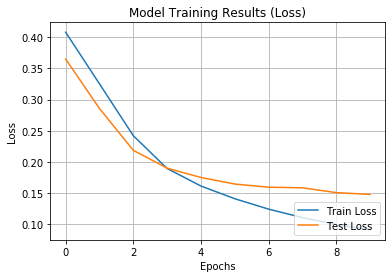

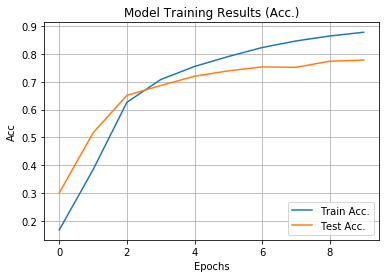

In [19]:
##### Loss #####
# Get training results
history_dict = history.history
train_loss = history_dict['loss']
test_loss = history_dict['val_loss']

# Plot training results
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')

# Show plot
plt.title('Model Training Results (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="lower right")
plt.grid()
plt.show()

##### Accuracy #####
# Get training results
history_dict = history.history
train_acc = history_dict['accuracy']
test_acc = history_dict['val_accuracy']

# Plot training results
plt.plot(train_acc, label='Train Acc.')
plt.plot(test_acc, label='Test Acc.')

# Show plot
plt.title('Model Training Results (Acc.)')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc="lower right")
plt.grid()
plt.show()


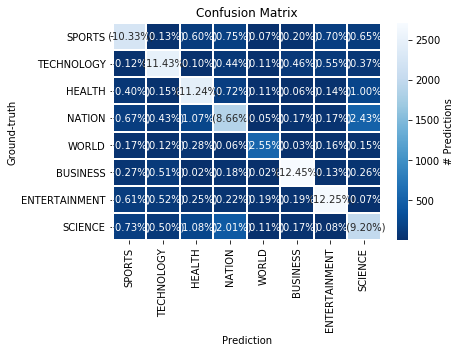

In [21]:
""" Confusion Matrix """
############################################
# Please DO NOT modify codes in this cell. #
############################################

# In this code block, we compute the confusion matrix using sklearn and 
# display the results with seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sn

CATEGORIES_TO_USE = ['SPORTS',
'TECHNOLOGY',
'HEALTH',
'NATION',
'WORLD',
'BUSINESS',
'ENTERTAINMENT',
'SCIENCE' ]

# Compute confusion matrix based on predictions
cm = confusion_matrix(
    np.argmax(y_traindev, axis=1),  # ground-truths
    np.argmax(model_rnn.predict(X_traindev_token), axis=1), # predictions
)
# Pack confusion matrix as a pd DataFrame for visualization using seaborn
df_cm = pd.DataFrame(
    cm, 
    index=CATEGORIES_TO_USE, columns=CATEGORIES_TO_USE
)

# Prepare annotations "# preds (percentage)" for visualization
annotations = [ 
    [ " ({:.2f}%)".format( value/len(y_traindev)*100) for value in row ] 
    for row in cm 
]

# Visualize confusion matrix using seaborn heatmap
sn.heatmap(df_cm, 
           annot=annotations, fmt='',
           cmap="Blues_r", cbar_kws={'label': '# Predictions'},
           linecolor='w', linewidths=1)

# Show plot
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Ground-truth")

plt.show()

In [23]:
from sklearn.metrics import  classification_report

print(classification_report(
    np.argmax(y_traindev, axis=1),  # ground-truths
    np.argmax(model_rnn.predict(X_traindev_token), axis=1),target_names=CATEGORIES_TO_USE)
)

               precision    recall  f1-score   support

       SPORTS       0.78      0.77      0.77      2922
   TECHNOLOGY       0.83      0.84      0.84      2952
       HEALTH       0.77      0.81      0.79      3006
       NATION       0.66      0.63      0.65      2970
        WORLD       0.79      0.73      0.76       764
     BUSINESS       0.91      0.90      0.90      3009
ENTERTAINMENT       0.86      0.86      0.86      3111
      SCIENCE       0.65      0.66      0.66      3021

     accuracy                           0.78     21755
    macro avg       0.78      0.78      0.78     21755
 weighted avg       0.78      0.78      0.78     21755

